# DESeq2 with Salmon and STAR

[Resources] (http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

In [1]:
library(ggplot2)
library(data.table)
library(limma)
library(DESeq2)
library(RColorBrewer)
library(tximport)
library(readr)
library(tximportData)
library(tximeta)
library(GenomicFeatures)
library(apeglm)
library(gplots)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following 

## Questions:
1) We know that Salmon is faster than STAR, but is it better?
2) How similar are Salmon and STAR in terms of differentially expressed genes?
3) How many replicates do we need?

**We have generated the quant.sh files from Salmon using the following commands:**
1) Generate a Salmon index (this takes about 8 minutes):

*/path_to/_where_you/_installed_salmon/bin/salmon index -t gencode.v44.transcripts.fa -i gencode_index --gencode*

2) Quant the samples:

*for i in *_R1.fastq.gz; do /path_to/_where_you/_installed_salmon/bin/salmon quant -i /path_to/_where_you/_output_your_index/gencode_index/ -l A -1 $i -2 ${i%_R1.fastq.gz}_R2.fastq.gz -p 13 --gcBias -o salmon_quant_output/${i%_R1.fastq.gz}_quant*

*done*

**How long did the quant take?**

Use a timer program in your script or if using a slurm system check by using (sacct -l -j <myid>). Alternatively, check the time stamp in the salmon_quant.log

First recorded time stamp: 2024-01-16 23:41:08.116


Last recorded time stamp: 2024-01-17 02:10:14.636


- took about two and a half hours for 20 samples or roughly 7.5 minutes per sample (run using 13 threads mem=96GB)

**What does a quant.sh file look like?**

Name	Length	EffectiveLength	TPM	NumReads

ENST00000456328.2	1657	1519.063	0.135470	15.498

ENST00000450305.2	632	393.000	0.000000	0.000

ENST00000488147.1	1351	1153.174	2.780315	241.453

ENST00000619216.1	68	68.000	0.000000	0.000

ENST00000473358.1	712	472.000	0.000000	0.000

ENST00000469289.1	535	297.000	0.000000	0.000

ENST00000607096.1	138	3.000	0.000000	0.000

ENST00000417324.1	1187	947.000	0.000000	0.000

Remember that these are pseudo-counts per transcript and we want counts per gene...

# Make a directory to store output

In [2]:
system("mkdir ~/module-4-rnaseq/Day2_materials/output")

# Step 1 for Salmon pseudo-count data
Use tximport to import and combine the quant.sh files created for each sample

In [3]:
#To use DESeq2 we need to first have a sample table that tells DESeq2 what samples we are interested in and an covariates we want to add to the GLM.
#First read in the sample table
samples <- read.table("./data/design_012424.csv", sep=',', header=TRUE)

In [4]:
#Take a look at the samples table
samples

sample,fetal_sex,cell_type
<chr>,<chr>,<chr>
CTB_1st_717,M,CTB_1st
CTB_1st_722,M,CTB_1st
CTB_1st_732,F,CTB_1st
CTB_1st_734,F,CTB_1st
CTB_1st_738,F,CTB_1st
CTB_1st_750,M,CTB_1st
CTB_1st_761,M,CTB_1st
CTB_1st_770,M,CTB_1st
CTB_1st_771,F,CTB_1st


Check to make sure everything is there...

In [5]:
files <- file.path("./salmon", samples$sample, "quant.sf")
all(file.exists(files))

[1] TRUE

Now we need to make the tx2gene file so that the transcripts can be associated with gene IDs for gene-level summarization. For this, we need to create a transcript to gene file that associates each transcript with its gene

In [6]:
gtfPath <- file.path("./data/", "gencode.v44.annotation.gtf.gz")
txdb <- makeTxDbFromGFF(file=gtfPath)
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")

Warning message in call_fun_in_txdbmaker("makeTxDbFromGFF", ...):
"makeTxDbFromGFF() has moved from GenomicFeatures to the txdbmaker package,
  and is formally deprecated in GenomicFeatures >= 1.59.1. Please call
  txdbmaker::makeTxDbFromGFF() to get rid of this warning."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
Warning message in .makeTxDb_normarg_chrominfo(chrominfo):
"genome version information is not available for this TxDb object"
OK

'select()' returned 1:1 mapping between keys and columns



In [7]:
names(files) <- paste0(samples$sample)
txi.salmon <- tximport(files, type = "salmon", tx2gene = tx2gene)
head(txi.salmon$counts)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 


summarizing abundance

summarizing counts

summarizing length



,CTB_1st_717,CTB_1st_722,CTB_1st_732,CTB_1st_734,CTB_1st_738,CTB_1st_750,CTB_1st_761,CTB_1st_770,CTB_1st_771,CTB_1st_772,EVT_1st_1026,EVT_1st_1087,EVT_1st_1089,EVT_1st_1094,EVT_1st_1096,EVT_1st_1097,EVT_1st_1099,EVT_1st_951,EVT_1st_970,EVT_1st_977
ENSG00000000003.16,617.255,827.000,679.008,605.000,928.549,507.000,634.018,576.277,544.000,469.000,538.000,612.195,438.999,395.001,579.000,693.999,431.352,287.000,743.005,529.000
ENSG00000000005.6,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSG00000000419.14,1989.558,2030.213,2243.393,1913.981,2886.329,1893.065,2323.905,2152.347,2218.117,2019.085,1035.932,986.999,964.391,830.999,1239.054,1045.642,831.480,676.037,1316.030,1111.171
ENSG00000000457.14,1192.783,1670.054,1197.001,972.996,1129.000,1038.574,977.513,881.000,936.469,989.310,350.004,351.001,418.000,341.000,517.982,473.000,302.054,238.102,534.998,338.000
ENSG00000000460.17,751.023,857.042,756.999,620.954,882.411,496.001,724.004,720.001,788.978,533.133,222.113,282.058,255.131,242.785,302.812,337.000,220.998,179.999,406.041,273.000
ENSG00000000938.13,4.000,1.000,0.000,0.000,1.000,4.000,0.000,0.000,1.000,0.000,29.000,25.000,22.000,30.000,73.000,33.000,60.000,18.000,116.000,7.000


Notice that we now no longer have ENST#'s but ENSG#'s. If we want to convert these to gene symbols we can do this using BioMart

In [8]:
write.table(txi.salmon$counts, "./output/salmon_counts.csv", sep=",")

# Creating DESeq2 object

Read in counts file back in:

In [9]:
counts<-read.csv("./output/salmon_counts.csv",header=TRUE,row.names=1)

Take a quick look at it

In [10]:
head(counts)

,CTB_1st_717,CTB_1st_722,CTB_1st_732,CTB_1st_734,CTB_1st_738,CTB_1st_750,CTB_1st_761,CTB_1st_770,CTB_1st_771,CTB_1st_772,EVT_1st_1026,EVT_1st_1087,EVT_1st_1089,EVT_1st_1094,EVT_1st_1096,EVT_1st_1097,EVT_1st_1099,EVT_1st_951,EVT_1st_970,EVT_1st_977
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.16,617.255,827.000,679.008,605.000,928.549,507.000,634.018,576.277,544.000,469.000,538.000,612.195,438.999,395.001,579.000,693.999,431.352,287.000,743.005,529.000
ENSG00000000005.6,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSG00000000419.14,1989.558,2030.213,2243.393,1913.981,2886.329,1893.065,2323.905,2152.347,2218.117,2019.085,1035.932,986.999,964.391,830.999,1239.054,1045.642,831.480,676.037,1316.030,1111.171
ENSG00000000457.14,1192.783,1670.054,1197.001,972.996,1129.000,1038.574,977.513,881.000,936.469,989.310,350.004,351.001,418.000,341.000,517.982,473.000,302.054,238.102,534.998,338.000
ENSG00000000460.17,751.023,857.042,756.999,620.954,882.411,496.001,724.004,720.001,788.978,533.133,222.113,282.058,255.131,242.785,302.812,337.000,220.998,179.999,406.041,273.000
ENSG00000000938.13,4.000,1.000,0.000,0.000,1.000,4.000,0.000,0.000,1.000,0.000,29.000,25.000,22.000,30.000,73.000,33.000,60.000,18.000,116.000,7.000


Take a look at how big the count matrix is

In [11]:
print(dim(counts))

[1] 62266    20


**Pre-Filtering**

A lot of these genes have no counts and could therefore be filtered out. While it is not necessary to pre-filter low count genes before running the DESeq2 functions, there are two reasons which make pre-filtering useful: by removing rows in which there are very few reads, we reduce the memory size of the dds data object, and we increase the speed of count modeling within DESeq2. It can also improve visualizations, as features with no information for differential expression are not plotted in dispersion plots or MA-plots.

Here if we wanted to do some pre-filtering to keep only rows that have a count of at least 10 for a minimal number of samples we would do the below. The count of 10 is a reasonable choice for bulk RNA-seq. A recommendation for the minimal number of samples is to specify the smallest group size, e.g. here there are 3 treated samples. If there are not discrete groups, one can use the minimal number of samples where non-zero counts would be considered interesting. One can also omit this step entirely and just rely on the independent filtering procedures available in results(), either IHW or genefilter.

In [12]:
#smallestGroupSize <- 3
#keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
#dds <- dds[keep,]

**Make DESeq2 object: Define counts matrix, groups, and design**
- countData: matrix of counts
- colData: dataframe with metadata for each sample
- design: name of column in colData we want to use as comparators

**Note about covariates, interactions, and multi-factor designs**
DESeq2 can analyze any possible experimental design that can be expressed with fixed effects terms (multiple factors, designs with interactions, designs with continuous variables, splines, and so on are all possible). By adding variables to the design, one can control for additional variation in the counts. For example, if the condition samples are balanced across experimental batches, by including the batch factor to the design, one can increase the sensitivity for finding differences due to condition. We can account for fetal_sex (or any other variable) and get a clearer picture of the differences attributable to the treatment (cell_type in our case). As cell_type is the variable of interest, we put it at the end of the formula. Thus the results function will by default pull the cell_type results unless contrast or name arguments are specified.

Most of the questions you have in the future will be having to do with this design formula. Please see the vignette and Google for more information:
https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#multi-factor-designs
https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#interactions

In [13]:
DESeq2CDS = DESeqDataSetFromTximport(txi.salmon, colData=samples, design=~fetal_sex + cell_type)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
using counts and average transcript lengths from tximport



This warning means that R is converting our text to categories.

# Run DESeq2

In [14]:
#We can now run the differential expression analysis using this one command:
dds <- DESeq(DESeq2CDS, parallel = TRUE)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 22 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 22 workers



A very quick and dirty QC is the dispersion plot. This plot is the estimate for the expected dispersion value for genes of a given expression strength. Each black dot is a gene with an associated mean expression level and maximum likelihood estimation (MLE) of the dispersion. This is a good plot to examine to ensure your data is a good fit for the DESeq2 model. You expect your data to generally scatter around the curve, with the dispersion decreasing with increasing mean expression levels. If you see a cloud or different shapes, then you might want to explore your data more to see if you have contamination (mitochondrial, etc.) or outlier samples. 

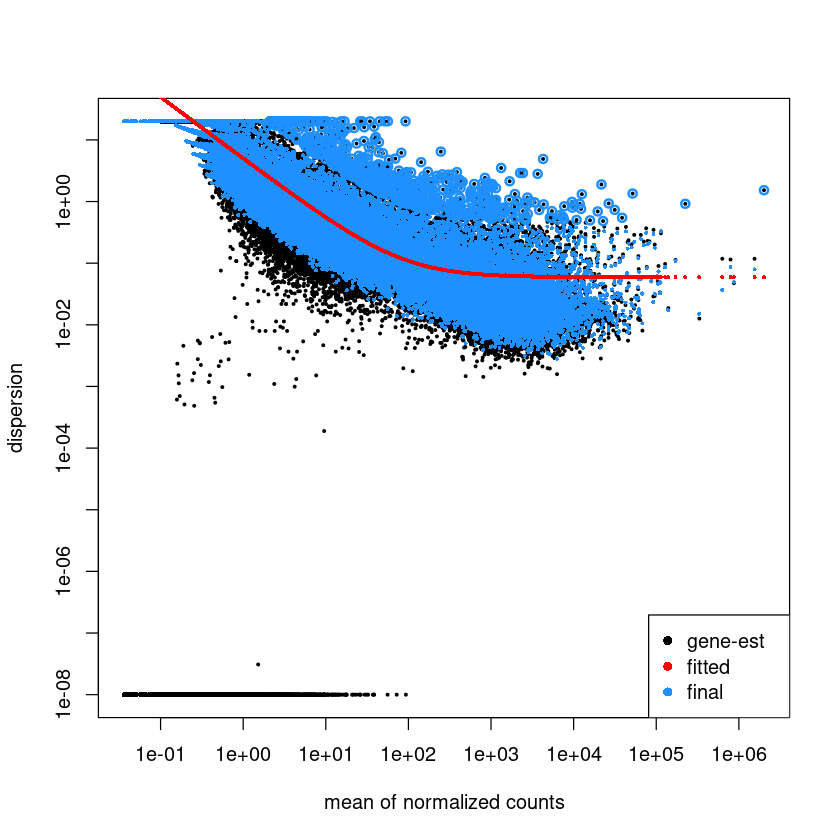

In [15]:
plotDispEsts(dds)

Let's take a quick look at the differential expression results:

In [16]:
res <- results(dds)
res

log2 fold change (MLE): cell type EVT 1st vs CTB 1st 
Wald test p-value: cell type EVT 1st vs CTB 1st 
DataFrame with 62266 rows and 6 columns
                      baseMean log2FoldChange     lfcSE       stat      pvalue
                     <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSG00000000003.16 5.72340e+02      0.2115040  0.118421  1.7860381 7.40931e-02
ENSG00000000005.6  8.86964e-02     -0.0817287  3.026188 -0.0270072 9.78454e-01
ENSG00000000419.14 1.49358e+03     -0.6038583  0.065251 -9.2543965 2.15444e-20
ENSG00000000457.14 6.85897e+02     -1.0252989  0.105869 -9.6846413 3.50436e-22
ENSG00000000460.17 4.63805e+02     -0.9734065  0.129510 -7.5160856 5.64406e-14
...                        ...            ...       ...        ...         ...
ENSG00000292259.1     0.000000             NA        NA         NA          NA
ENSG00000292271.1     0.000000             NA        NA         NA          NA
ENSG00000292277.1   163.794906       0.225631  0.187379   1.204139 

Details about the comparison are printed to the console, directly above the results table. The text, condition treated vs untreated, tells you that the estimates are of the logarithmic fold change log2(EVT 1st/CTB 1st).

With no additional arguments to results, the log2 fold change and Wald test p value will be for the last variable in the design formula, and if this is a factor, the comparison will be **the last level of this variable over the reference level**. By default, R will choose a reference level for factors based on alphabetical order. Then, if you never tell the DESeq2 functions which level you want to compare against (e.g. which level represents the control group), the comparisons will be based on the alphabetical order of the levels. Normally you will want to explicitly tell results which comparison to make using the contrast argument, or you can explicitly set the factors levels (we won't be going over this). The order of the variables of the design do not matter so long as the user specifies the comparison to build a results table for, using the name or contrast arguments of results. Note that we have changed the order of cell type in this comparison.

In [17]:
res_test <- results(dds, contrast=c("cell_type","CTB_1st","EVT_1st"))
res_test

log2 fold change (MLE): cell_type CTB_1st vs EVT_1st 
Wald test p-value: cell_type CTB_1st vs EVT_1st 
DataFrame with 62266 rows and 6 columns
                      baseMean log2FoldChange     lfcSE       stat      pvalue
                     <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSG00000000003.16 5.72340e+02     -0.2115040  0.118421 -1.7860381 7.40931e-02
ENSG00000000005.6  8.86964e-02      0.0817287  3.026188  0.0270072 9.78454e-01
ENSG00000000419.14 1.49358e+03      0.6038583  0.065251  9.2543965 2.15444e-20
ENSG00000000457.14 6.85897e+02      1.0252989  0.105869  9.6846413 3.50436e-22
ENSG00000000460.17 4.63805e+02      0.9734065  0.129510  7.5160856 5.64406e-14
...                        ...            ...       ...        ...         ...
ENSG00000292259.1     0.000000             NA        NA         NA          NA
ENSG00000292271.1     0.000000             NA        NA         NA          NA
ENSG00000292277.1   163.794906      -0.225631  0.187379  -1.204139 

The results function contains a number of arguments to customize the results table which is generated. You can read about these arguments by looking up ?results. Note that the results function automatically performs independent filtering based on the mean of normalized counts for each gene, optimizing the number of genes which will have an adjusted p value below a given FDR cutoff, alpha. By default the argument alpha is set to 0.1. If the adjusted p value cutoff will be a value other than 0.1, alpha should be set to that value:

In [18]:
#Because 0.05 is more generally expcepted we should do:
res05 <- results(dds, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
summary(res05)


out of 39876 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 7774, 19%
LFC < 0 (down)     : 7441, 19%
outliers [1]       : 348, 0.87%
low counts [2]     : 11253, 28%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [19]:
#If we want to know how many genes in total were differentially expressed we could do
sum(res05$padj < 0.05, na.rm=TRUE)

[1] 15215

# Normalization and Results Exporting

DESeq2 doesn’t use normalized counts, rather it uses the raw counts and models the normalization inside the Generalized Linear Model (GLM). It does perform normalization as we discussed in class and we can output the normalized data to use in other ways.

DESeq2 uses size factors to normalize data and if we would like to see these factors we can use the function [`estimateSizeFactors()`](https://rdrr.io/bioc/DESeq2/man/estimateSizeFactors.html), which "estimates the size factors using the "median ratio method" described by Equation 5 in Anders and Huber (2010)".

We can extract the normalized counts using counts() with the parameter normalized=TRUE.

In [20]:
normalized_counts_salmon10 <- counts(dds, normalized=TRUE)
write.table(normalized_counts_salmon10, file="./output/DESeq2normalized_counts_salmon.txt", sep="\t", quote=F, col.names=NA)

We also often want to export our results so to do that we can do:

In [21]:
#Sort our results file by adjusted p-value
res_salmon10 <- res05[order(res05$padj),]

#Then merge it with our normalized data table that we output above
resdata_salmon10 <- merge(as.data.frame(res_salmon10), as.data.frame(normalized_counts_salmon10), by="row.names", sort=FALSE)
write.table(resdata_salmon10,file="./output/DESeq2_resultsalpha0_05_salmon10.txt",sep="\t")

# QC and exploration of DESeq2 Results

**MA Plot**

In DESeq2, the function plotMA shows the log2 fold changes attributable to a given variable over the mean of normalized counts for all the samples in the DESeqDataSet. Points will be colored blue if the adjusted p value is less than 0.1. Points which fall out of the window are plotted as open triangles pointing either up or down.

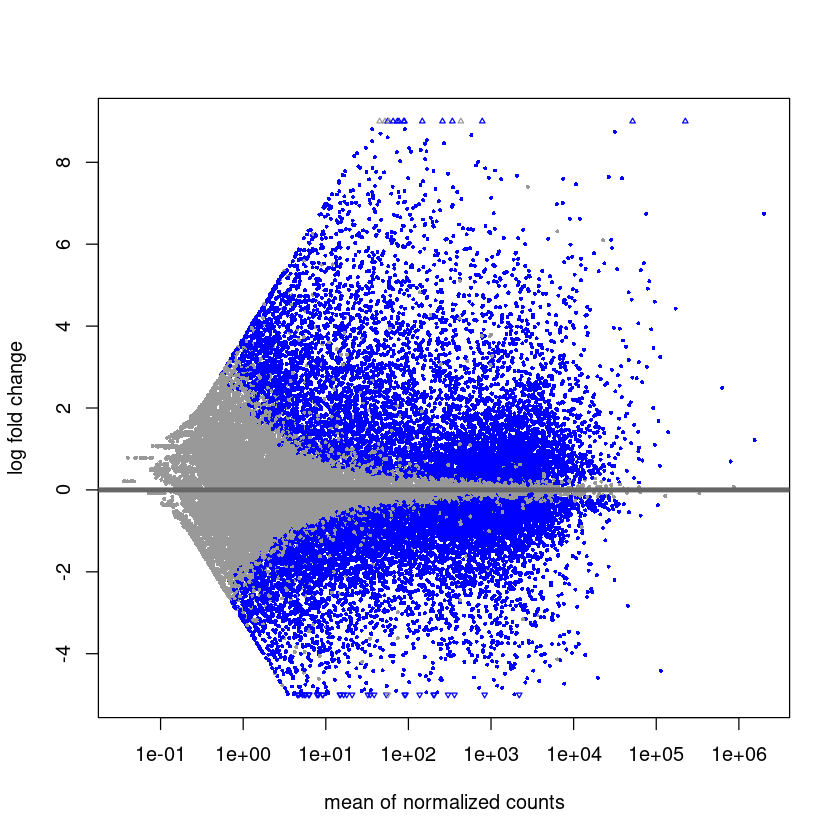

In [22]:
plotMA(res, ylim=c(-5,9))

It is more useful to visualize the MA-plot for the shrunken log2 fold changes, which remove the noise associated with log2 fold changes from low count genes without requiring arbitrary filtering thresholds.

In [23]:
resultsNames(dds)

[1] "Intercept"                    "fetal_sex_M_vs_F"            
[3] "cell_type_EVT_1st_vs_CTB_1st"

In [24]:
#Log fold change shrinkage for visualization and ranking
resLFC <- lfcShrink(dds, coef="cell_type_EVT_1st_vs_CTB_1st",type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



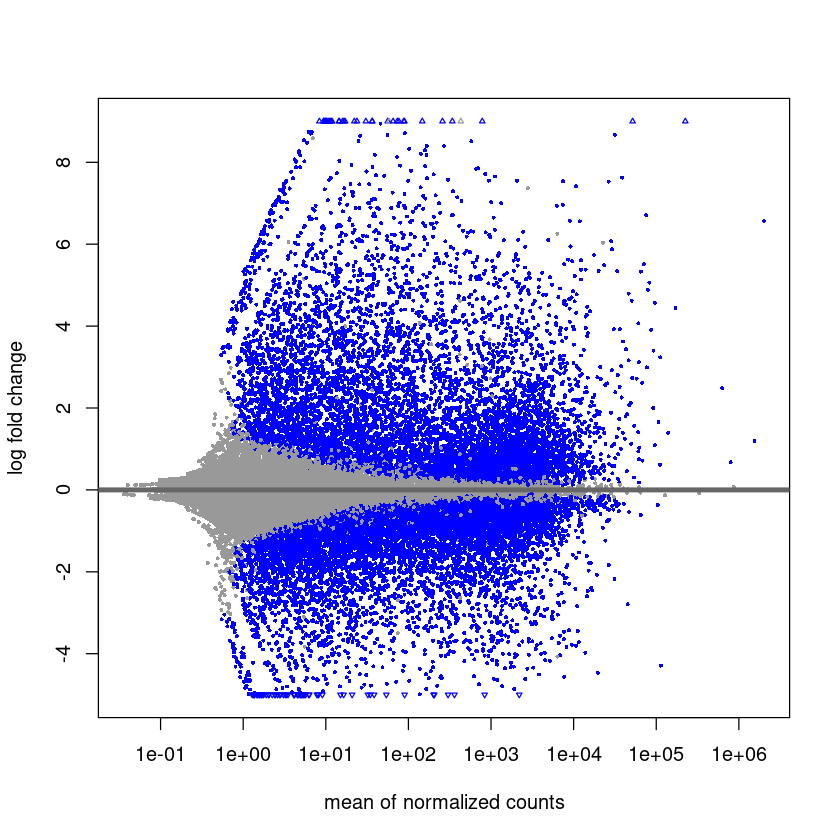

In [25]:
#Now we can plot the MA with these values
plotMA(resLFC, ylim=c(-5,9))

## PCA Plot
Related to the distance matrix is the PCA plot, which shows the samples in the 2D plane spanned by their first two principal components. This type of plot is useful for visualizing the overall effect of experimental covariates and batch effects.

We need to first transform the data to better visualize it. To do this we can use either variance stabilizing transformation (vst) or regularized log transformation using `rlog()`. Variance stabilizing transformation which is roughly similar to putting the data on the log2 scale, while also dealing with the sampling variability of low counts. It uses the design formula to calculate the within-group variability (if blind=FALSE) or the across-all-samples variability (if blind=TRUE). It does not use the design to remove variation in the data. It therefore does not remove variation that can be associated with batch or other covariates (nor does DESeq2 have a way to specify which covariates are nuisance and which are of interest).

It is possible to visualize the transformed data with batch variation removed, using the removeBatchEffect function from limma. This simply removes any shifts in the log2-scale expression data that can be explained by batch.

In [26]:
vsd <- vst(dds, blind=FALSE)

using ntop=500 top features by variance



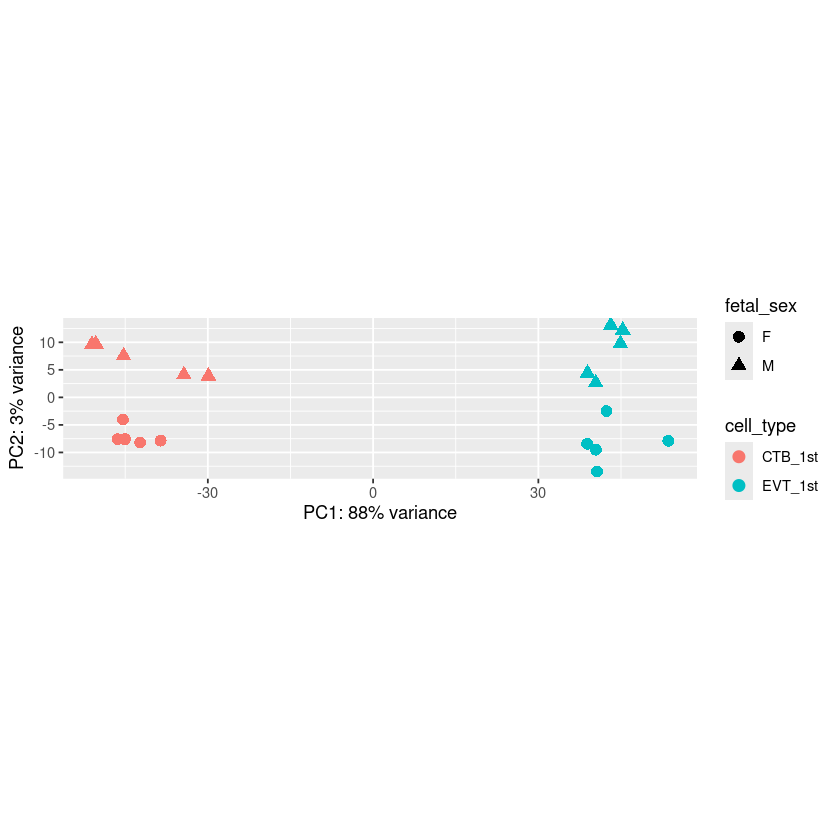

In [27]:
#plot PCA
pcaData <- plotPCA(vsd, intgroup = c("cell_type","fetal_sex"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=cell_type, shape=fetal_sex)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

## Heatmap of sample-to-sample distances

A heatmap of this distance matrix gives us an overview over similarities and dissimilarities between samples.

The dist() function "computes and returns the distance matrix computed by using the specified distance measure to compute the distances between the rows of a data matrix".


In [28]:
#visualize sample distances
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
head(sampleDistMatrix)

,CTB_1st_717,CTB_1st_722,CTB_1st_732,CTB_1st_734,CTB_1st_738,CTB_1st_750,CTB_1st_761,CTB_1st_770,CTB_1st_771,CTB_1st_772,EVT_1st_1026,EVT_1st_1087,EVT_1st_1089,EVT_1st_1094,EVT_1st_1096,EVT_1st_1097,EVT_1st_1099,EVT_1st_951,EVT_1st_970,EVT_1st_977
CTB_1st_717,0.00000,76.13996,74.55655,77.12535,72.31875,77.48007,74.36950,76.70307,73.09792,75.56996,158.3275,162.7382,152.9236,153.8132,152.3043,151.6730,155.7752,177.2417,158.9383,159.8173
CTB_1st_722,76.13996,0.00000,63.86268,61.15547,60.02850,61.05443,66.38377,65.51313,64.59538,66.14184,142.8496,144.4682,133.6236,136.7152,135.0690,133.5502,141.8188,162.4601,139.7785,142.3240
CTB_1st_732,74.55655,63.86268,0.00000,51.39600,50.53614,56.20265,55.42561,57.50245,48.93183,47.26221,157.5506,160.5457,150.2195,153.4627,150.7126,148.5787,153.8005,174.5754,154.0329,158.6348
CTB_1st_734,77.12535,61.15547,51.39600,0.00000,48.64242,54.96622,57.35346,55.10302,53.13725,52.02237,148.4286,150.3852,140.2088,145.0727,140.9691,138.1377,146.6681,167.0146,143.4894,148.9451
CTB_1st_738,72.31875,60.02850,50.53614,48.64242,0.00000,57.41297,52.94592,51.89096,51.77944,52.36912,156.3192,157.3635,147.7292,151.7907,148.1120,145.9970,154.3820,174.7315,152.0011,156.0600
CTB_1st_750,77.48007,61.05443,56.20265,54.96622,57.41297,0.00000,55.19252,59.26324,59.31151,53.34106,147.0320,150.0180,139.0568,142.6587,142.1513,139.7397,144.8285,165.3920,144.9477,148.6059


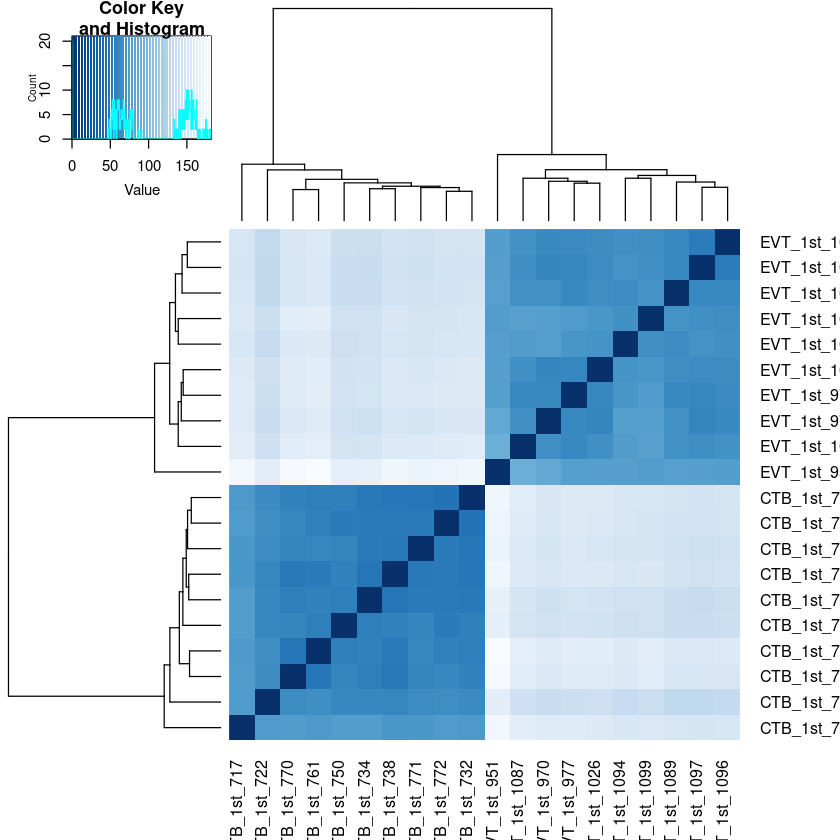

In [29]:
#Plot using heatmap2
colours = colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
heatmap.2(sampleDistMatrix, trace="none", col=colours)

## Volcano plot

The volcano plot enables to simultaneously capture the effect size and significance (ordinate) of each tested gene.

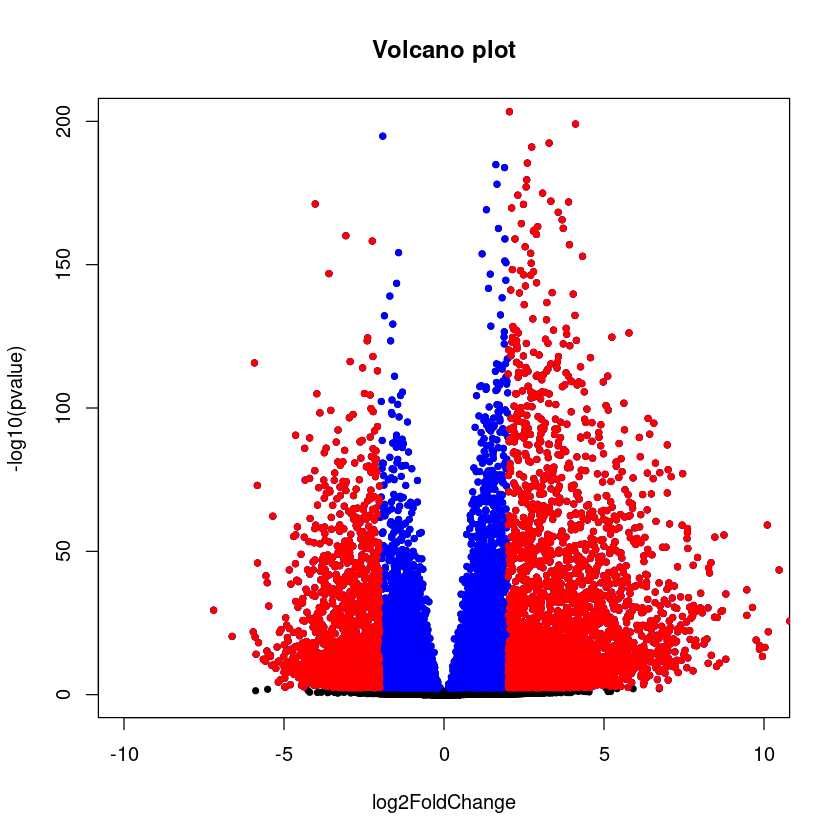

In [30]:
#volcano plot
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-10,10),ylim=c(0,200)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))

# How many samples do you need?

**First Re-run with the salmon output**

In [31]:
#I need to read in the design meta-data first as well as the count matix that we exported from salmon
design8 = read.csv("./data/design_012424_8samples.csv", header=TRUE)
files <- file.path("./salmon", design8$sample, "quant.sf")
gtfPath <- file.path("./data/", "gencode.v44.annotation.gtf.gz")
txdb <- makeTxDbFromGFF(file=gtfPath)
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")
names(files) <- paste0(design8$sample)
txi.salmon <- tximport(files, type = "salmon", tx2gene = tx2gene)

Warning message in call_fun_in_txdbmaker("makeTxDbFromGFF", ...):
"makeTxDbFromGFF() has moved from GenomicFeatures to the txdbmaker package,
  and is formally deprecated in GenomicFeatures >= 1.59.1. Please call
  txdbmaker::makeTxDbFromGFF() to get rid of this warning."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
Warning message in .makeTxDb_normarg_chrominfo(chrominfo):
"genome version information is not available for this TxDb object"
OK

'select()' returned 1:1 mapping between keys and columns

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 


summarizing abundance

summarizing counts

summarizing length



**Now re-run DESeq2**

In [32]:
DESeq2CDS_s8 = DESeqDataSetFromTximport(txi.salmon, colData=design8, design=~fetal_sex + cell_type)
#Run DESeq2
dds_s8 <- DESeq(DESeq2CDS_s8, parallel = TRUE)
res_s8 <- results(dds_s8, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_s8$padj < 0.05, na.rm=TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 22 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 22 workers



[1] 13847

**Now repeat for 6 samples per group, then 4, and finally 3**

In [33]:
#I need to read in the design meta-data first as well as the count matix that we exported from salmon
design6 = read.csv("./data/design_012424_6samples.csv", header=TRUE)
files <- file.path("./salmon", design6$sample, "quant.sf")
gtfPath <- file.path("./data", "gencode.v44.annotation.gtf.gz")
txdb <- makeTxDbFromGFF(file=gtfPath)
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")
names(files) <- paste0(design6$sample)
txi.salmon <- tximport(files, type = "salmon", tx2gene = tx2gene)
DESeq2CDS_s6 = DESeqDataSetFromTximport(txi.salmon, colData=design6, design=~fetal_sex + cell_type)
#Run DESeq2
dds_s6 <- DESeq(DESeq2CDS_s6, parallel = TRUE)
res_s6 <- results(dds_s6, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_s6$padj < 0.05, na.rm=TRUE)

Warning message in call_fun_in_txdbmaker("makeTxDbFromGFF", ...):
"makeTxDbFromGFF() has moved from GenomicFeatures to the txdbmaker package,
  and is formally deprecated in GenomicFeatures >= 1.59.1. Please call
  txdbmaker::makeTxDbFromGFF() to get rid of this warning."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
Warning message in .makeTxDb_normarg_chrominfo(chrominfo):
"genome version information is not available for this TxDb object"
OK

'select()' returned 1:1 mapping between keys and columns

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


summarizing abundance

summarizing counts

summarizing length

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in desi

[1] 12126

In [34]:
#I need to read in the design meta-data first as well as the count matix that we exported from salmon
design4 = read.csv("./data/design_012424_4samples.csv", header=TRUE)
files <- file.path("./salmon", design4$sample, "quant.sf")
gtfPath <- file.path("./data", "gencode.v44.annotation.gtf.gz")
txdb <- makeTxDbFromGFF(file=gtfPath)
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")
names(files) <- paste0(design4$sample)
txi.salmon <- tximport(files, type = "salmon", tx2gene = tx2gene)
DESeq2CDS_s4 = DESeqDataSetFromTximport(txi.salmon, colData=design4, design=~fetal_sex + cell_type)
#Run DESeq2
dds_s4 <- DESeq(DESeq2CDS_s4, parallel = TRUE)
res_s4 <- results(dds_s4, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_s4$padj < 0.05, na.rm=TRUE)

Warning message in call_fun_in_txdbmaker("makeTxDbFromGFF", ...):
"makeTxDbFromGFF() has moved from GenomicFeatures to the txdbmaker package,
  and is formally deprecated in GenomicFeatures >= 1.59.1. Please call
  txdbmaker::makeTxDbFromGFF() to get rid of this warning."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
Warning message in .makeTxDb_normarg_chrominfo(chrominfo):
"genome version information is not available for this TxDb object"
OK

'select()' returned 1:1 mapping between keys and columns

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 


summarizing abundance

summarizing counts

summarizing length

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are 

[1] 8309

In [35]:
#I need to read in the design meta-data first as well as the count matix that we exported from salmon
design3 = read.csv("./data/design_012424_3samples.csv", header=TRUE)
files <- file.path("./salmon", design3$sample, "quant.sf")
gtfPath <- file.path("./data", "gencode.v44.annotation.gtf.gz")
txdb <- makeTxDbFromGFF(file=gtfPath)
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")
names(files) <- paste0(design3$sample)
txi.salmon <- tximport(files, type = "salmon", tx2gene = tx2gene)
DESeq2CDS_s3 = DESeqDataSetFromTximport(txi.salmon, colData=design3, design=~fetal_sex + cell_type)
#Run DESeq2
dds_s3 <- DESeq(DESeq2CDS_s3, parallel = TRUE)
res_s3 <- results(dds_s3, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_s3$padj < 0.05, na.rm=TRUE)

Warning message in call_fun_in_txdbmaker("makeTxDbFromGFF", ...):
"makeTxDbFromGFF() has moved from GenomicFeatures to the txdbmaker package,
  and is formally deprecated in GenomicFeatures >= 1.59.1. Please call
  txdbmaker::makeTxDbFromGFF() to get rid of this warning."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
Warning message in .makeTxDb_normarg_chrominfo(chrominfo):
"genome version information is not available for this TxDb object"
OK

'select()' returned 1:1 mapping between keys and columns

reading in files with read_tsv

1 
2 
3 
4 
5 
6 


summarizing abundance

summarizing counts

summarizing length

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are charac

[1] 7277

## **How does this compare to mapping with STAR?**

In [36]:
design = read.csv("./data/design_012424.csv", header=TRUE, row.names=1)
star = read.csv("./data/BNFO262_01232024_counts.csv", header=TRUE, row.names=1)
DESeq2CDS_star = DESeqDataSetFromMatrix(countData=star, colData=design, design=~fetal_sex + cell_type)
dds_star <- DESeq(DESeq2CDS_star, parallel = TRUE)
res_star <- results(dds_star, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_star$padj < 0.05, na.rm=TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 22 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 22 workers



[1] 16307

Now look at 8, 6, 4, and 3 samples:

In [37]:
design_star8 = read.csv("./data/design_012424_8samples.csv", header=TRUE, row.names=1)
star_8 = read.csv("./data/BNFO262_01232024_counts_8.csv", header=TRUE, row.names=1)
DESeq2CDS_star8 = DESeqDataSetFromMatrix(countData=star_8, colData=design_star8, design=~fetal_sex + cell_type)
dds_star8 <- DESeq(DESeq2CDS_star8, parallel = TRUE)
res_star8 <- results(dds_star8, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_star8$padj < 0.05, na.rm=TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 22 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 22 workers



[1] 14986

In [38]:
design_star6 = read.csv("./data/design_012424_6samples.csv", header=TRUE, row.names=1)
star_6 = read.csv("./data/BNFO262_01232024_counts_6.csv", header=TRUE, row.names=1)
DESeq2CDS_star6 = DESeqDataSetFromMatrix(countData=star_6, colData=design_star6, design=~fetal_sex + cell_type)
dds_star6 <- DESeq(DESeq2CDS_star6, parallel = TRUE)
res_star6 <- results(dds_star6, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_star6$padj < 0.05, na.rm=TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 22 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 22 workers



[1] 13154

In [39]:
design_star4 = read.csv("./data/design_012424_4samples.csv", header=TRUE, row.names=1)
star_4 = read.csv("./data/BNFO262_01232024_counts_4.csv", header=TRUE, row.names=1)
DESeq2CDS_star4 = DESeqDataSetFromMatrix(countData=star_4, colData=design_star4, design=~fetal_sex + cell_type)
dds_star4 <- DESeq(DESeq2CDS_star4, parallel = TRUE)
res_star4 <- results(dds_star4, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differentially expressed
sum(res_star4$padj < 0.05, na.rm=TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 22 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 22 workers



[1] 9120

In [40]:
design_star3 = read.csv("./data/design_012424_3samples.csv", header=TRUE, row.names=1)
star_3 = read.csv("./data/BNFO262_01232024_counts_3.csv", header=TRUE, row.names=1)
DESeq2CDS_star3 = DESeqDataSetFromMatrix(countData=star_3, colData=design_star3, design=~fetal_sex + cell_type)
dds_star3 <- DESeq(DESeq2CDS_star3, parallel = TRUE)
res_star3 <- results(dds_star3, alpha=0.05,contrast=c("cell_type","EVT_1st","CTB_1st"))
#How many genes in total are differential
sum(res_star3$padj < 0.05, na.rm=TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 22 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 22 workers



[1] 8061

In [41]:
star_salmon_degs <- read.csv("./data/DEGs_salmon_star.csv", header=TRUE)
star_salmon_df <- data.frame(star_salmon_degs)
star_salmon_df

Samples_per_group,Salmon,Star
<int>,<int>,<int>
10,15215,16307
8,13847,14986
6,12126,13154
4,8309,9120
3,7277,8061
